### ISC among twins and non-twins

The goal of this notebook is to measure ISC among twins and compare it against non-twins.

#### Import modules

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random
import numpy as np
import pandas as pd
from tqdm import tqdm
#from nilearn import plotting, maskers, datasets, image
#from nilearn.masking import compute_brain_mask, apply_mask
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr
#from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [4]:
n_regions        = 293
fmri_data_file   = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file = '../data/02_rois_masks_maps/allcombined.nii'
twin_df_file     = '../data/00_dataset_info/twin_df.csv'

#### Load viewer info, set up masker, load timeseries

In [5]:
twin_df   = pd.read_csv(twin_df_file)
twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

#print(' ')

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data  = np.swapaxes(ts_array, 0, 2)
ts_data  = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure (all viewers, to compute basic ISC): " + str(ts_data.shape))

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]
Shape of time series structure (all viewers, to compute basic ISC): (380, 293, 200)


In [6]:
p_val_twins  = []
p_val_others  = []

null_distributions = []

r_val_twins  = []
r_val_others = []

# Computing ISC (functional) for the real twins
n_twins         = len(twin_list)
iscs_reg_twin   = np.zeros((n_regions+1, n_twins)) #the additional line is for the anatomical similarity
#null_distributions = []

for curr_region in tqdm(range(293)):
    #print(curr_region)
    twin_iscs      = []

    #print(curr_region)
    data_roi_df = pd.DataFrame(ts_data[:,curr_region,:], columns = list(np.hstack((twin_df.twin_A_id.values, twin_df.twin_B_id.values)).flatten()) )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True, tail = 1, ci_percentile = 99)
    #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    null_distributions.append(stats_boot['null_distribution'])
    
    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        curr_isc = np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1]
        twin_iscs.append(curr_isc)
 
    iscs_reg_twin[curr_region, :]   = twin_iscs #'''

    curr_mean = fisher_z_to_r(np.mean(fisher_r_to_z(twin_iscs))) 
    #print(curr_mean)
    p_val_twins.append(percentage_larger_elements(stats_boot['null_distribution'], curr_mean))
    p_val_others.append(stats_boot['p'])

    r_val_twins.append(curr_mean)
    r_val_others.append(stats_boot['isc'])


100%|█████████████████████████████████████████| 293/293 [03:04<00:00,  1.59it/s]


In [6]:
mask = Brain_Data(all293_rois_file)
mask_x = expand_mask(mask)
alpha = 0.05

# map isc results back to brain
isc_r_brain, isc_p_brain           = roi_to_brain(pd.Series(r_val_twins), mask_x), roi_to_brain(pd.Series(p_val_twins), mask_x)
isc_otherr_brain, isc_otherp_brain = roi_to_brain(pd.Series(r_val_others), mask_x), roi_to_brain(pd.Series(p_val_others), mask_x)
isc_diff_brain                     = roi_to_brain(pd.Series(np.asarray(r_val_twins) - np.asarray(r_val_others)), mask_x)

result_image_twins  = threshold(isc_r_brain,      isc_p_brain,      thr = fdr(isc_p_brain.data,      q = alpha)).to_nifti()
result_image_others = threshold(isc_otherr_brain, isc_otherp_brain, thr = fdr(isc_otherp_brain.data, q = alpha)).to_nifti()
result_image_diff   = threshold(isc_diff_brain,   isc_p_brain,      thr = fdr(isc_p_brain.data,      q = alpha)).to_nifti()


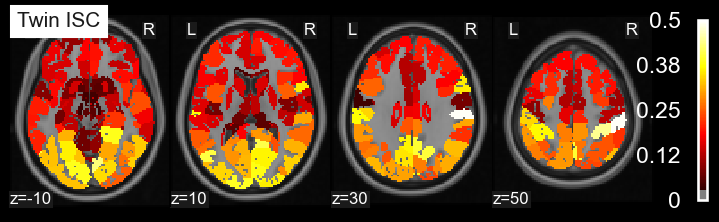

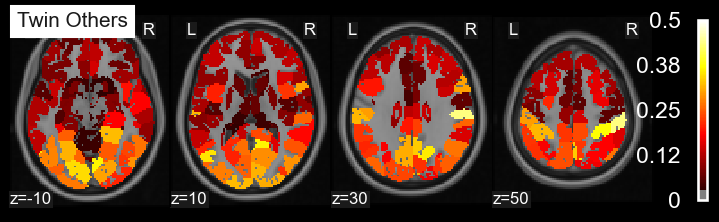

In [32]:
# visualize results
max = 0.5

fig = plt.figure(figsize=(7, 2))
nilearn.plotting.plot_stat_map(    result_image_twins, 
                                   bg_img='../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = max, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -10, 10, 30, 50],
                                   annotate     = True,
                                   title        = 'Twin ISC',
                                   figure = fig);

# visualize results
fig = plt.figure(figsize=(7, 2))
nilearn.plotting.plot_stat_map(    result_image_others, 
                                   bg_img='../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = max, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -10, 10, 30, 50],
                                   annotate     = True,
                                   title        = 'Twin Others',
                                   figure = fig);





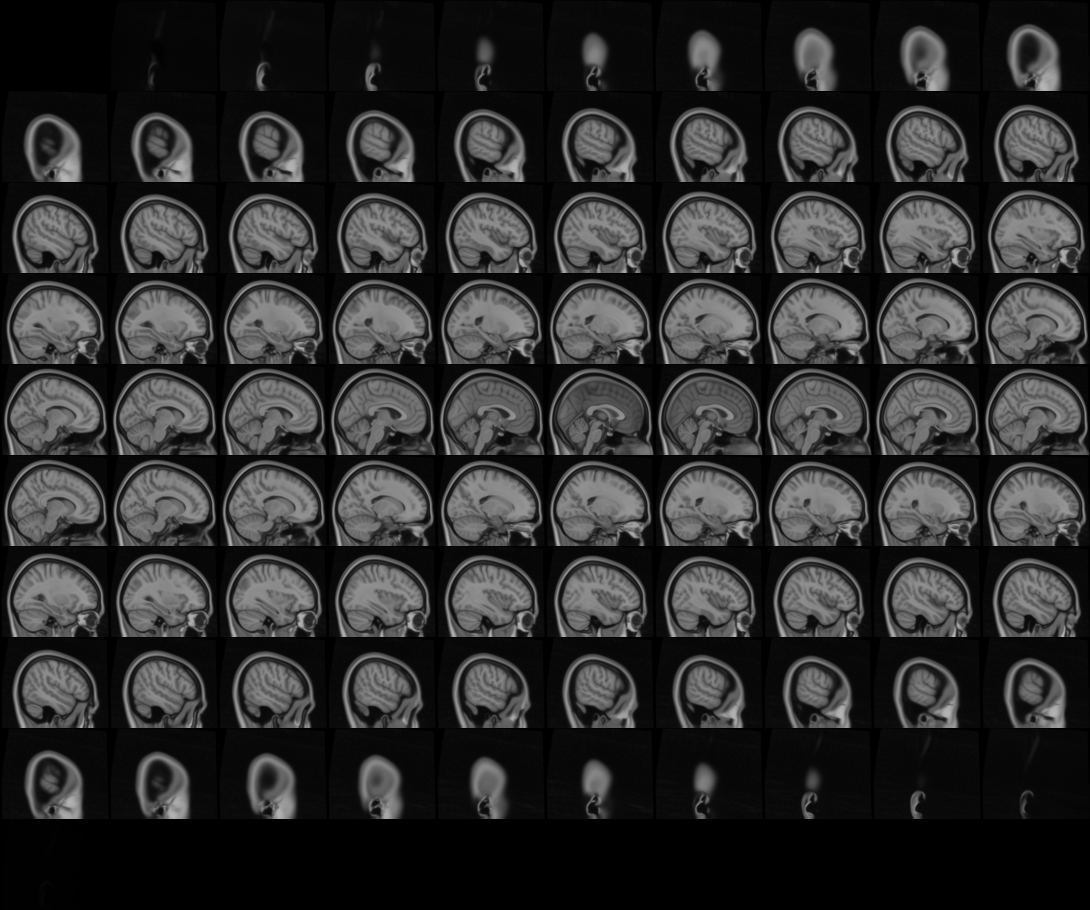
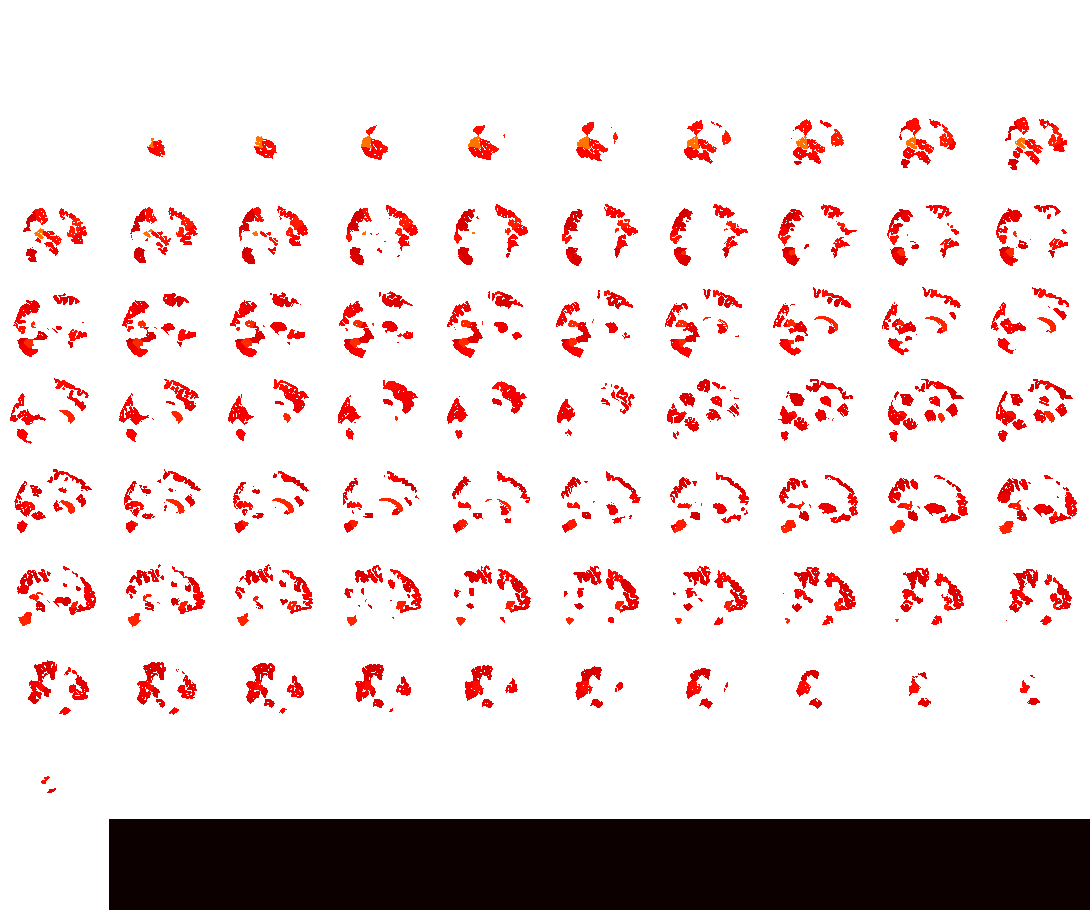

In [33]:
v = nilearn.plotting.view_img(    result_image_diff, 
                                   bg_img='../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.06,  #additional threshold for visualization
                                   vmax         = 0.2,
                                   title        = 'ISC(Twins) - ISC(Others)',);
v

In [35]:
# How many regions survive? 
p_val_twins_array = np.asarray(p_val_twins).reshape(293,1).T
print(p_val_twins_array.shape)
q                 = multipletests(p_val_twins_array[0, :], method='fdr_by')[1]
corrected         = q[np.newaxis, :] < alpha
print(len(corrected[corrected == False]))
print(corrected.shape[1] - len(corrected[corrected == False]))

(1, 293)
17
276


#### Plot ISC(Twins) vs. ISC(Others)

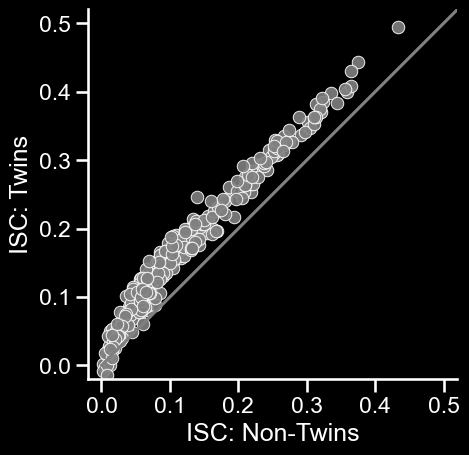

In [36]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

sns.scatterplot(x = r_val_others, 
                y = r_val_twins,
                color = 'gray', alpha = 0.9)

plt.axis('square');
plt.xlim(-0.02,.52); plt.ylim(-0.02,.52);
plt.plot([0, 1], [0, 1], color = 'gray');
plt.xticks(ticks=[0, .1, .2, .3, .4,.5]); plt.yticks(ticks=[0, .1, .2, .3 ,.4,.5])
plt.xlabel('ISC: Non-Twins'); plt.ylabel('ISC: Twins');
sns.despine()

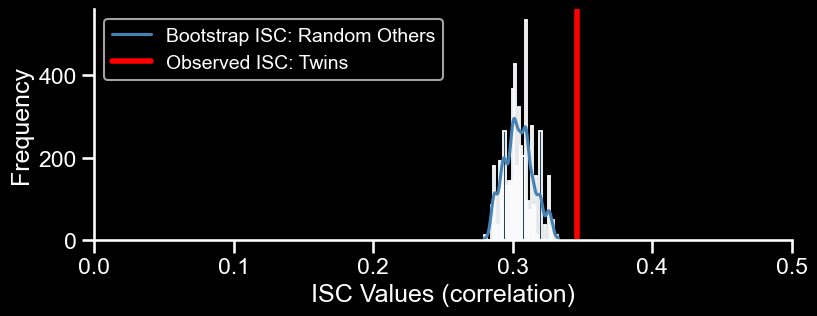

In [37]:
region_to_plot = 75
fs = 14

dist = null_distributions[region_to_plot]
twin_r = r_val_twins[region_to_plot]

plt.figure(figsize=(9,3));
sns.histplot(dist , kde=True, label='Bootstrap', color="steelblue");
plt.xlim([0, 0.5])

plt.ylabel('Frequency'); plt.xlabel('ISC Values (correlation)');
plt.axvline(twin_r, linestyle='-', color='red', linewidth=4);
plt.legend(['Bootstrap ISC: Random Others', 'Observed ISC: Twins'],  loc = 2, fontsize=fs),
sns.despine()    
plt.show()